In [1]:

import json
import random
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize


nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

#Downlaod Vectorizer here:
# Word2Vec:
# https://drive.usercontent.google.com/download?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download&authuser=0

#Glove:
#https://nlp.stanford.edu/projects/glove/

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/erikrubinov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/erikrubinov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/erikrubinov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
data = json.loads(open("../data/processed/Oppositional_thinking_analysis_dataset.json").read())

In [3]:
selected_instances = random.sample(data, 15)

In [4]:
def preprocess_advanced(text:str, lem_tag = True, stem_tag = False) -> int:

    # Lowercasing
    text = text.lower()
    text = re.sub(r'\d+', '', text) # remove decimals  
    text = re.sub(r'[\:\-\']', '', text)  # Remove specific punctuation
    text = re.sub(r'http\S+', '', text) # Remove URLs
    text = re.sub(r'\s+', ' ', text) # Remove extra whitespace
    text = re.sub(r'[^\w\s]', '', text) # Remove special characters
    text = re.sub(r'\d+\.\d+', '', text)  # Matches one or more digits followed by a dot and one or more digits
    text = re.sub(r'\bcom\b', '', text, flags=re.IGNORECASE)  # Matches "com" at word boundaries (whole word)


    # Tokenization
    tokens = word_tokenize(text)

    # Removing stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    if lem_tag:
    # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    if stem_tag:
        stemmer = PorterStemmer()
        tokens = [stemmer.stem(word) for word in tokens]

    return tokens
    #return ' '.join(tokens)

In [5]:
preprocessed_texts = [preprocess_advanced(instance['text'], True) for instance in selected_instances]


In [6]:
##Use Glove vecors 

# Load GloVe vectors (adjust the path to where your GloVe file is located)
def load_glove_vectors(glove_file):
    embeddings_index = {}
    with open(glove_file, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index



In [7]:
def average_word_vectors(tokens, embeddings_index):
    valid_vectors = [embeddings_index[word] for word in tokens if word in embeddings_index]
    if valid_vectors:
        return np.mean(valid_vectors, axis=0)
    else:
        return np.zeros(100)  # Assuming GloVe 100d vectors



In [8]:
glove_file = '/Users/erikrubinov/Desktop/SM24/NLP/glove.6B/glove.6B.100d.txt'  # Path to GloVe file
embeddings_index = load_glove_vectors(glove_file)
sentence_vectors = [average_word_vectors(tokens, embeddings_index) for tokens in preprocessed_texts]

In [9]:
def cosine_similarities_man(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)



report = []
for i in range(len(selected_instances)):
    for j in range(i + 1, len(selected_instances)):
        cosine_sim = cosine_similarities_man(sentence_vectors[i], sentence_vectors[j])
        report.append({
            'sentence1_id': selected_instances[i]['id'],
            'sentence2_id': selected_instances[j]['id'],
            'cosine_similarity': cosine_sim
        })


## Visualize Heatmap similarity  

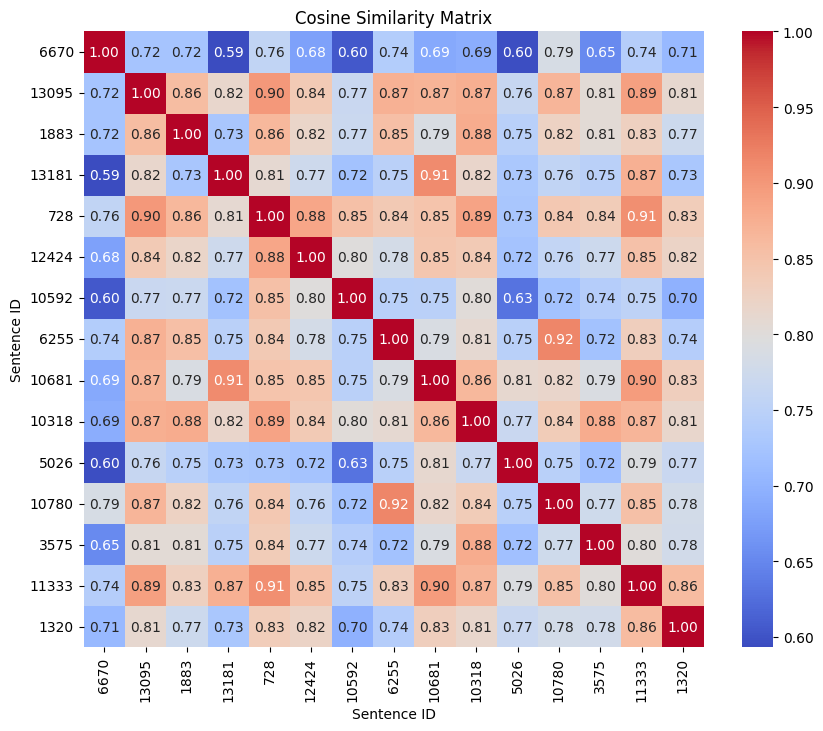

In [10]:
n = len(selected_instances)
similarity_matrix = np.zeros((n, n))

for item in report:
    idx1 = selected_instances.index(next(inst for inst in selected_instances if inst['id'] == item['sentence1_id']))
    idx2 = selected_instances.index(next(inst for inst in selected_instances if inst['id'] == item['sentence2_id']))
    similarity_matrix[idx1, idx2] = item['cosine_similarity']
    similarity_matrix[idx2, idx1] = item['cosine_similarity']  # since cosin similaritx is symmetric...

# Set diagonal to 1 since its the similarity of the sentences with themselves
np.fill_diagonal(similarity_matrix, 1)

sentence_ids = [inst['id'] for inst in selected_instances]
df_sim_matrix = pd.DataFrame(similarity_matrix, index=sentence_ids, columns=sentence_ids)


plt.figure(figsize=(10, 8))
sns.heatmap(df_sim_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Cosine Similarity Matrix')
plt.xlabel('Sentence ID')
plt.ylabel('Sentence ID')
plt.show()

## In the following we also use the Word2Vec vectorizer and calculate cosine similarity to compare the results

In [11]:


import gensim.downloader as api
word2vec_model = api.load('word2vec-google-news-300')

In [ ]:
import pickle

file = open('word2vec-model.pkl', 'wb')
pickle.dump(word2vec_model, file)
file.close()

In [ ]:
model_path = '/Users/erikrubinov/Desktop/SM24/NLP/word2vec-model.pkl'

# Load the model
with open(model_path, 'rb') as f:
    word2vec_model = pickle.load(f)

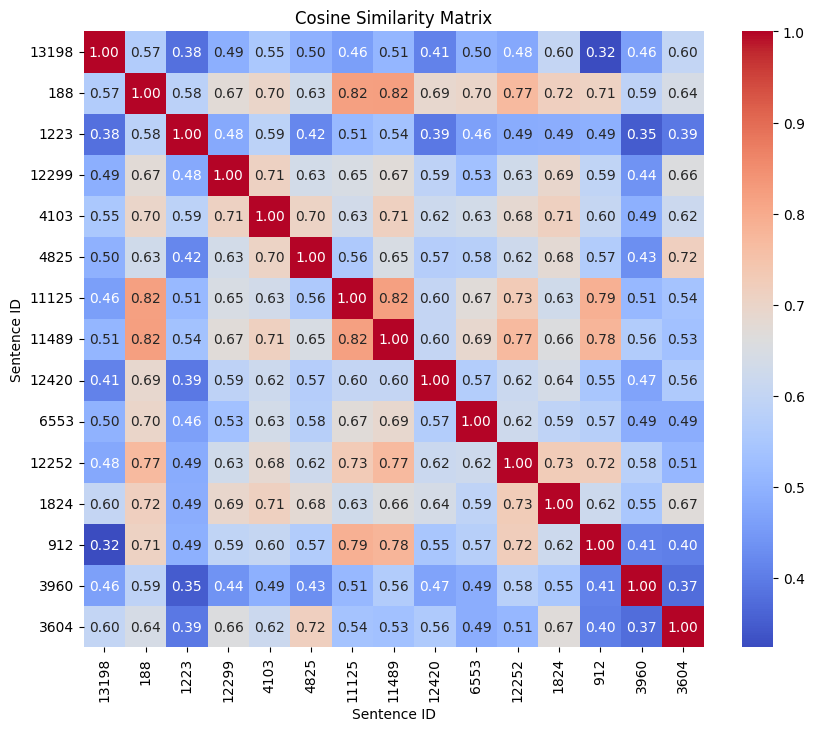

In [ ]:
sentence_vectors = [average_word_vectors(tokens, word2vec_model) for tokens in preprocessed_texts]



report = []
for i in range(len(selected_instances)):
    for j in range(i + 1, len(selected_instances)):
        cosine_sim = cosine_similarities_man(sentence_vectors[i], sentence_vectors[j])
        report.append({
            'sentence1_id': selected_instances[i]['id'],
            'sentence2_id': selected_instances[j]['id'],
            'cosine_similarity': cosine_sim
        })


n = len(selected_instances)
similarity_matrix = np.zeros((n, n))

for item in report:
    idx1 = selected_instances.index(next(inst for inst in selected_instances if inst['id'] == item['sentence1_id']))
    idx2 = selected_instances.index(next(inst for inst in selected_instances if inst['id'] == item['sentence2_id']))
    similarity_matrix[idx1, idx2] = item['cosine_similarity']
    similarity_matrix[idx2, idx1] = item['cosine_similarity']  # since cosin similaritx is symmetric...

# Set diagonal to 1 since its the similarity of the sentences with themselves
np.fill_diagonal(similarity_matrix, 1)

sentence_ids = [inst['id'] for inst in selected_instances]
df_sim_matrix = pd.DataFrame(similarity_matrix, index=sentence_ids, columns=sentence_ids)


plt.figure(figsize=(10, 8))
sns.heatmap(df_sim_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Cosine Similarity Matrix')
plt.xlabel('Sentence ID')
plt.ylabel('Sentence ID')
plt.show()